In [2]:
from PIL import Image

In [3]:
import onnx

In [4]:
import numpy as np
import pandas as pd

In [5]:
import onnxruntime as ort

In [105]:
import torch
import torchvision
import torchvision.transforms as T

In [20]:
import torchvision

In [114]:
import matplotlib.pyplot as plt

In [6]:
model = onnx.load("bisenetv2_11.onnx")

In [7]:
onnx.checker.check_model(model)

In [128]:
img = Image.open("190516_102815_00381.png")

In [134]:
new_img = img.resize((1024, 512))

In [151]:
input_ = (np.asarray(new_img).astype(np.float32))

In [149]:
[1, 3, 512, 1024]

[1, 3, 512, 1024]

In [152]:
input_.shape

(512, 1024, 3)

In [10]:
session = ort.InferenceSession("bisenetv2_11.onnx")

In [119]:
input_name = session.get_inputs()[0].name
outputs = session.run(None, {input_name: input_})

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Invalid rank for input: input Got: 3 Expected: 4 Please fix either the inputs or the model.

In [17]:
outputs[0].shape

(1, 11, 512, 1024)

In [114]:
## the output "masks" is of shape [batchsize]x[num_classes]x[height]x[width] (for example 1x6x512x1024)

In [25]:
masks = torch.from_numpy(outputs[0])

In [46]:
max = masks.max(1)
masksMax = max[0]
masksInd = max[1]

In [47]:
masksInd = masksInd + 1

In [49]:
threshold = 0.5
threshold = np.log(threshold/(1 - threshold))

In [50]:
masksMax = masksMax > threshold

In [101]:
masks_onechannel = masksMax * masksInd
masks_onechannel = masks_onechannel.unsqueeze_(0);
masks_onechannel = masks_onechannel.to(torch.float32)

In [102]:
torch.nn.UpsamplingNearest2d(masks_onechannel, (img.width, img.height))

UpsamplingNearest2d(scale_factor=(1280.0, 1024.0), mode=nearest)

In [103]:
masks_onechannel = masks_onechannel.to(torch.uint8)
masks_onechannel.squeeze

<function Tensor.squeeze>

In [110]:
masks_onechannel_cv = T.ToPILImage(masks_onechannel)

In [112]:
def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

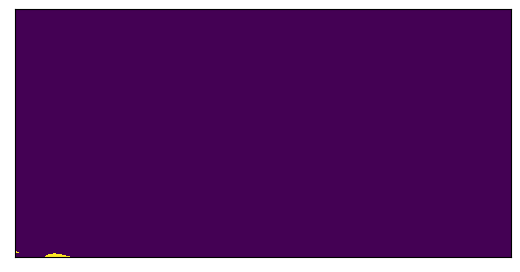

In [116]:
show(masks_onechannel)

In [36]:
ort.get_device()

'CPU'

In [13]:
pipeline = Pipeline("bisenetv2_11.onnx")

In [38]:
img.size

(1280, 1024)

In [14]:
IN_IMAGE_H = pipeline.session.get_inputs()[0].shape[2]
IN_IMAGE_W = pipeline.session.get_inputs()[0].shape[3]
input_array = np.ones((1, 3, IN_IMAGE_H, IN_IMAGE_W)).astype(np.float32)

In [83]:
pipeline.session.get_inputs()[0].shape

[1, 3, 512, 1024]

In [77]:
input_name = pipeline.session.get_inputs()[0].name

In [78]:
type(result)

NoneType

In [91]:
result = pipeline(input_array)

In [76]:
dir(result)

['__bool__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [103]:
 boxes = post_processing(input_array, 0.4, 0.6, outputs)

NameError: name 'post_processing' is not defined

In [9]:
class Pipeline:
    def __init__(self, path_model):
        super(Pipeline, self).__init__()
        self.session = self.load_model(path_model)

    def load_model(self, path_model: str) -> object:
        """
        Загружаем модель в формате onnx/torchscript
        :param path_model: путь
        """
        providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if ort.get_device() == "GPU" else ['CPUExecutionProvider']
        return ort.InferenceSession(path_model, providers=providers)

    def __call__(self, input: np.array) -> np.array:
        """
        инференс нейросети
        :param input: сам входной массив
        """
            # Input
        self.session.run(None, {input_name: input})